Note: Much of this code was lifted from [the Conversation AI project](https://conversationai.github.io/). In this file, instead of using max DI I want to do each of the DIs against gay and basically plot a bunch of lines on the same axis, di of input and di of output but one line for white, one line for black, one line for jewish etc

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # comment this out if higher resolution is not needed

Read TSVs from file. These are the original data from *Conversation AI*.

In [2]:
THRESHOLD_BINARY_TOXICITY = 0.5

def read_files():
    comments = pd.read_csv("toxicity_annotated_comments.tsv"\
                                          , sep = "\t")
    annotations = pd.read_csv("toxicity_annotations.tsv"\
                                          , sep = "\t")
    # toxicity_worker_demographics = pd.read_csv("toxicity_worker_demographics.tsv"\
#                                           , sep = "\t")
    grouped_annotations = annotations.groupby('rev_id',as_index=False)['toxicity'].mean()
    joined_tox = grouped_annotations.join(comments, lsuffix='rev_id', rsuffix='rev_id', how='left', sort=True) 
    joined_tox['binary_tox'] = np.where(joined_tox['toxicity']>=THRESHOLD_BINARY_TOXICITY, 1, 0)
    
    # remove newline and tab tokens
    joined_tox['comment'] = joined_tox.comment.apply(lambda x: x.replace('NEWLINE_TOKEN', '').replace('TAB_TOKEN', ''))
    joined_tox['len_comment'] = joined_tox.comment.apply(lambda x: len(x))
    
    return joined_tox


In [3]:
def split_test_train(joined_tox):
    test_comments = joined_tox.query("split == 'test' ")
    train_comments = joined_tox.query("split == 'train' ")
    
    return test_comments, train_comments

In [4]:
def add_identity_terms(test_comments, train_comments):

    # Currently not in use, but possibly we'll switch to use this later

    # TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
    #               'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
    #               'homosexual', 'heterosexual', 'straight',
    #               'muslim', 'jewish', 'jew', 'christian',
    #               'feminist', 'black', 'white']

    madlibs_terms = model_bias_analysis.read_identity_terms('adjectives_people.txt')

    # Add identity labels to train and test comments
    model_bias_analysis.add_subgroup_columns_from_text(train_comments, 'comment', madlibs_terms)
    model_bias_analysis.add_subgroup_columns_from_text(test_comments, 'comment', madlibs_terms)
    
    return madlibs_terms

* *grouped_annotations* takes the mean of all toxicity ratings of a comment.
* *joined_tox* joins *grouped_annotations* and *comments*.
* We also add a column *binary_tox* to the dataframe *joined_tox*. Here we assign a toxicity rating of 0 or 1 based on whether the mean toxicity rating is above or below 0.5 (or other value determined by threshold_binary_toxicity

In [20]:
# joined_tox = read_files()
# test_comments, train_comments = split_test_train(joined_tox)
# madlibs_terms = add_identity_terms(test_comments, train_comments)

# This writes the 3 dataframes to csv so that we can read from that later for shorter code.
# joined_tox.to_csv('joined_tox.csv')
# train_comments.to_csv('train_comments.csv')
# test_comments.to_csv('test_comments.csv')

# Either use this or the commented-out stuff above. That (above) reads all of the actual files and generates df's
# This (below) reads pre-generated df's so that we don't have to run all the 3 functions above each time. 

joined_tox = pd.read_csv('joined_tox.csv')
train_comments = pd.read_csv('train_comments.csv')
test_comments = pd.read_csv('test_comments.csv')
madlibs_terms = model_bias_analysis.read_identity_terms('adjectives_people.txt')

In [21]:
# list(joined_tox)
joined_tox = joined_tox[joined_tox['len_comment'] < 180]

In [22]:
# Data cleaning needed:
# What identity terms are we taking out and why? Brandons' initial suggestion was in less than 5% of toxic comments
# But we might have to do less than 5% of toxic comments WITH an identity term
# I also think it's really important to balance by comment length...but how?

# Another thing to check for data cleaning. Are we using the test set determined in the paper?

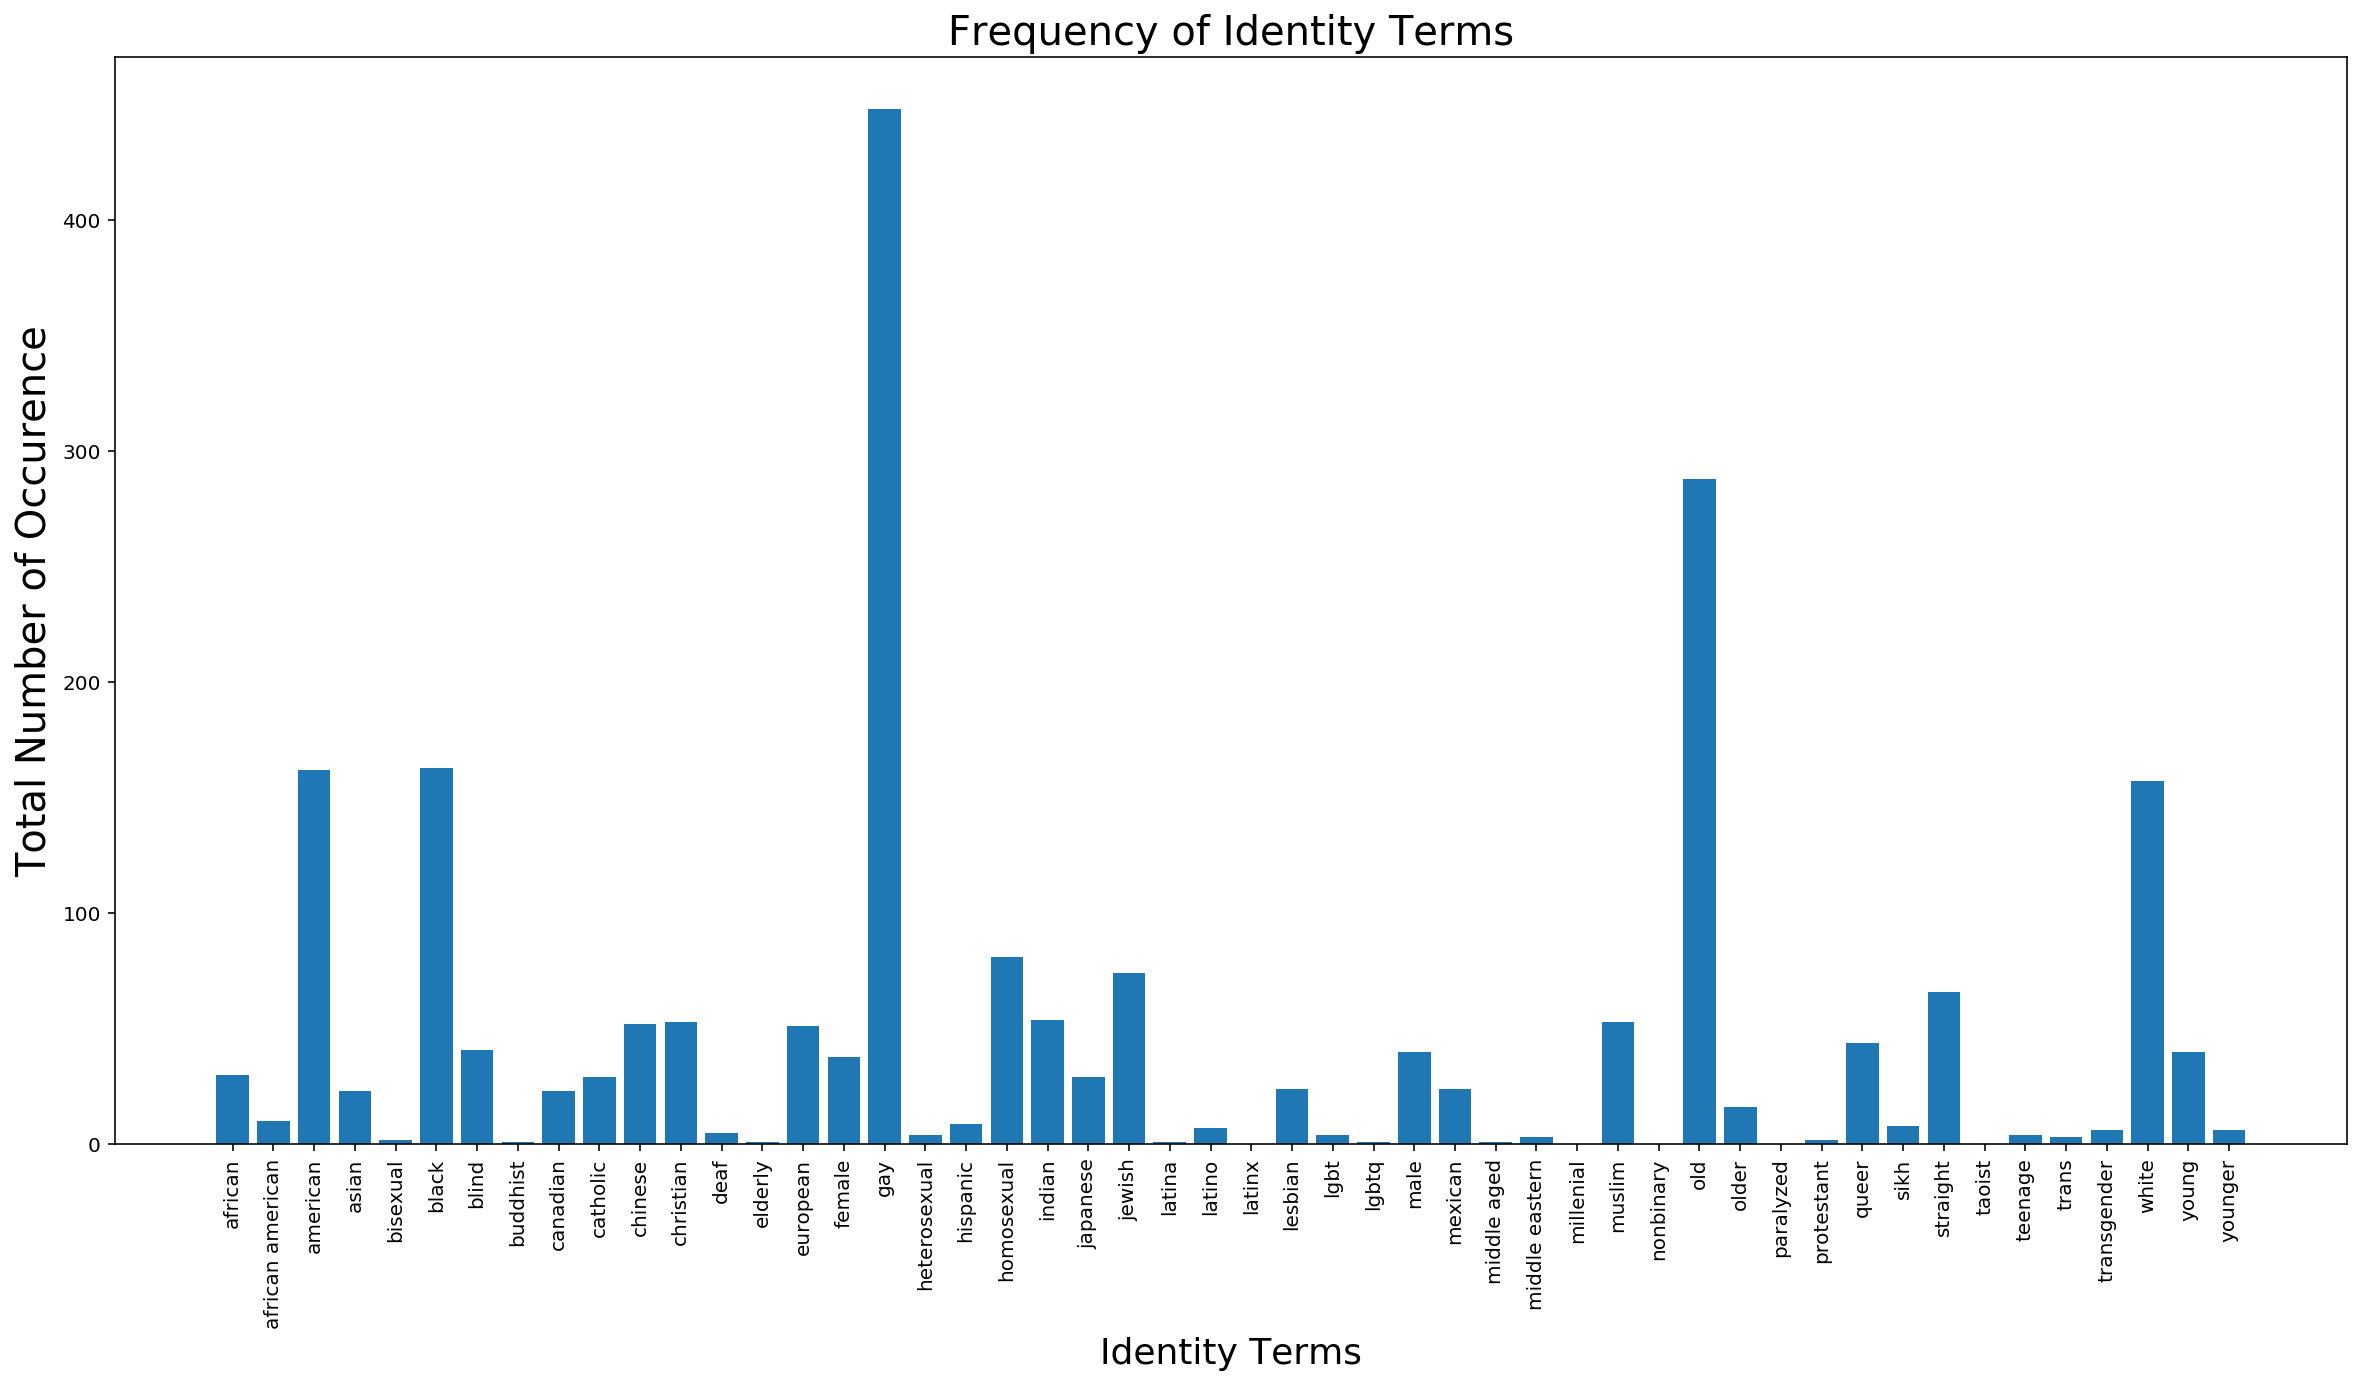

In [26]:
# Here, I plot how often each identity term appears
# Part of the effort to clean the data by ensuring that I don't use words that never appear!

num_toxic_train = []
num_toxic_test = []

training_toxic_rows = train_comments[train_comments["binary_tox"] == 1]
test_toxic_rows = test_comments[test_comments["binary_tox"] == 1]

for i in range(len(madlibs_terms)):
    num_toxic_train.append(training_toxic_rows.iloc[:,11+i].sum())
    num_toxic_test.append(test_toxic_rows.iloc[:,11+i].sum())
#print(num_toxic_train)
#print(num_toxic_test)

toxic_appearances = np.add(num_toxic_train, num_toxic_test)
# So array element 0 is how often madLibs_terms index 0 appeared in comments that are toxic in both test and training, etc
plt.figure(figsize=(20,10))
plt.bar(madlibs_terms, toxic_appearances)
plt.xticks(rotation=90)
plt.xlabel('', fontsize=18)
plt.title("Frequency of Identity Terms", fontsize=20)
plt.ylabel('Total Number of Occurence', fontsize=20)
plt.xlabel('Identity Terms')
# urgh will need to space this out really hard. Maybe rank it, too. 

plt.savefig('Freq_of_Ti.png', bbox_inches='tight')

In [109]:

# plt.figure(figsize=(20,10))
# # c = np.array(list(zip(madlibs_terms,toxic_appearances)))

# plt.bar(range(len(toxic_appearances)),toxic_appearances)
# plt.xticks(range(len(toxic_appearances)),madlibs_terms )
# # plt.bar(df.sort_values("toxic_appearances")['madlibs_terms'], df.sort_values("toxic_appearances")['toxic_appearances'])
# plt.xticks(rotation=90)
# plt.xlabel('', fontsize=10)
# plt.title("Frequency of Identity Terms")
# plt.ylabel('Total Number of Occurence')
# plt.xlabel('Identity Terms')

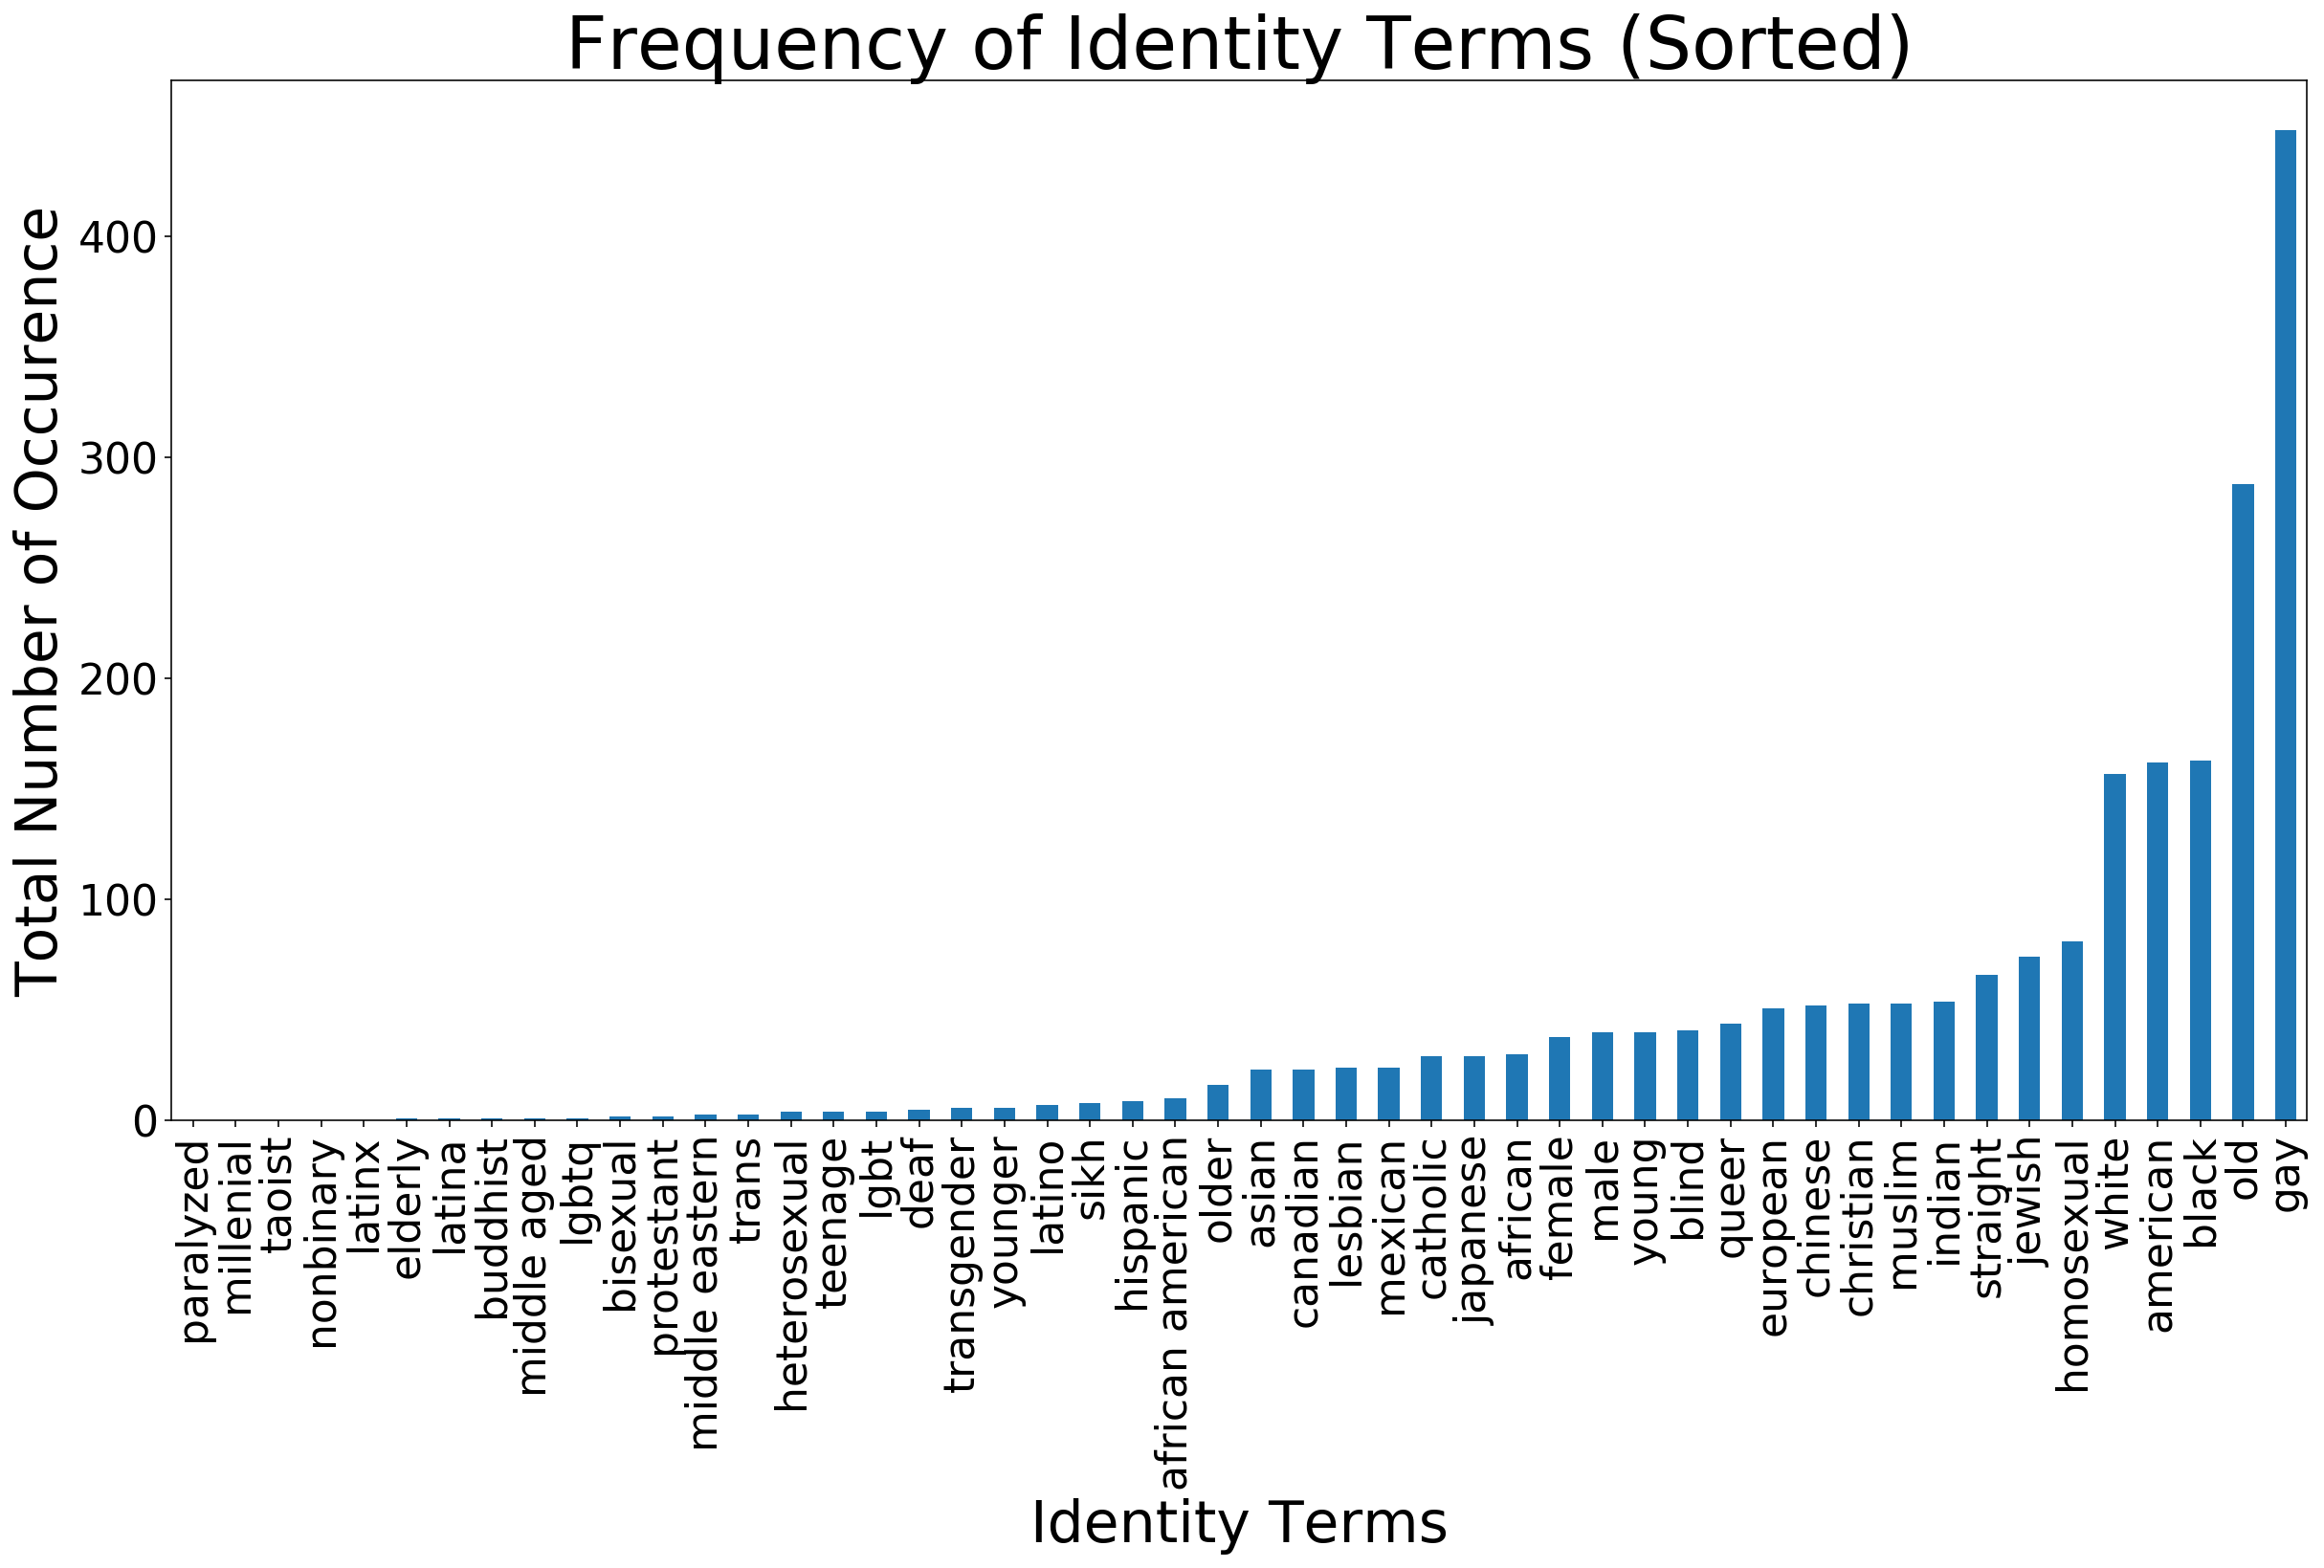

In [45]:
# toxic_appearances
# madlibs_terms
# plt.figure(figsize=(10,20))
# plt.barh(range(len(madlibs_terms)),toxic_appearances)

# plt.yticks(range(len(madlibs_terms)),madlibs_terms)
df = pd.DataFrame(list(zip(madlibs_terms, toxic_appearances))).set_index(0).sort_values(by=[1])
ax = df.plot.bar(figsize = (20,10), legend=False, title= "Frequency of Identity Terms (Sorted)", fontsize=22)#, x='Identity Terms', y='Total Number of Occurence')
ax.title.set_size(38)
# df.plot.title('Frequency of Identity Terms (Sorted)', fontsize=20)
ax.set_xlabel("Identity Terms",  fontsize=30)
ax.set_ylabel("Total Number of Occurence", fontsize=30)
plt.savefig('Freq_of_Ti_sorted.png', bbox_inches='tight')

# df

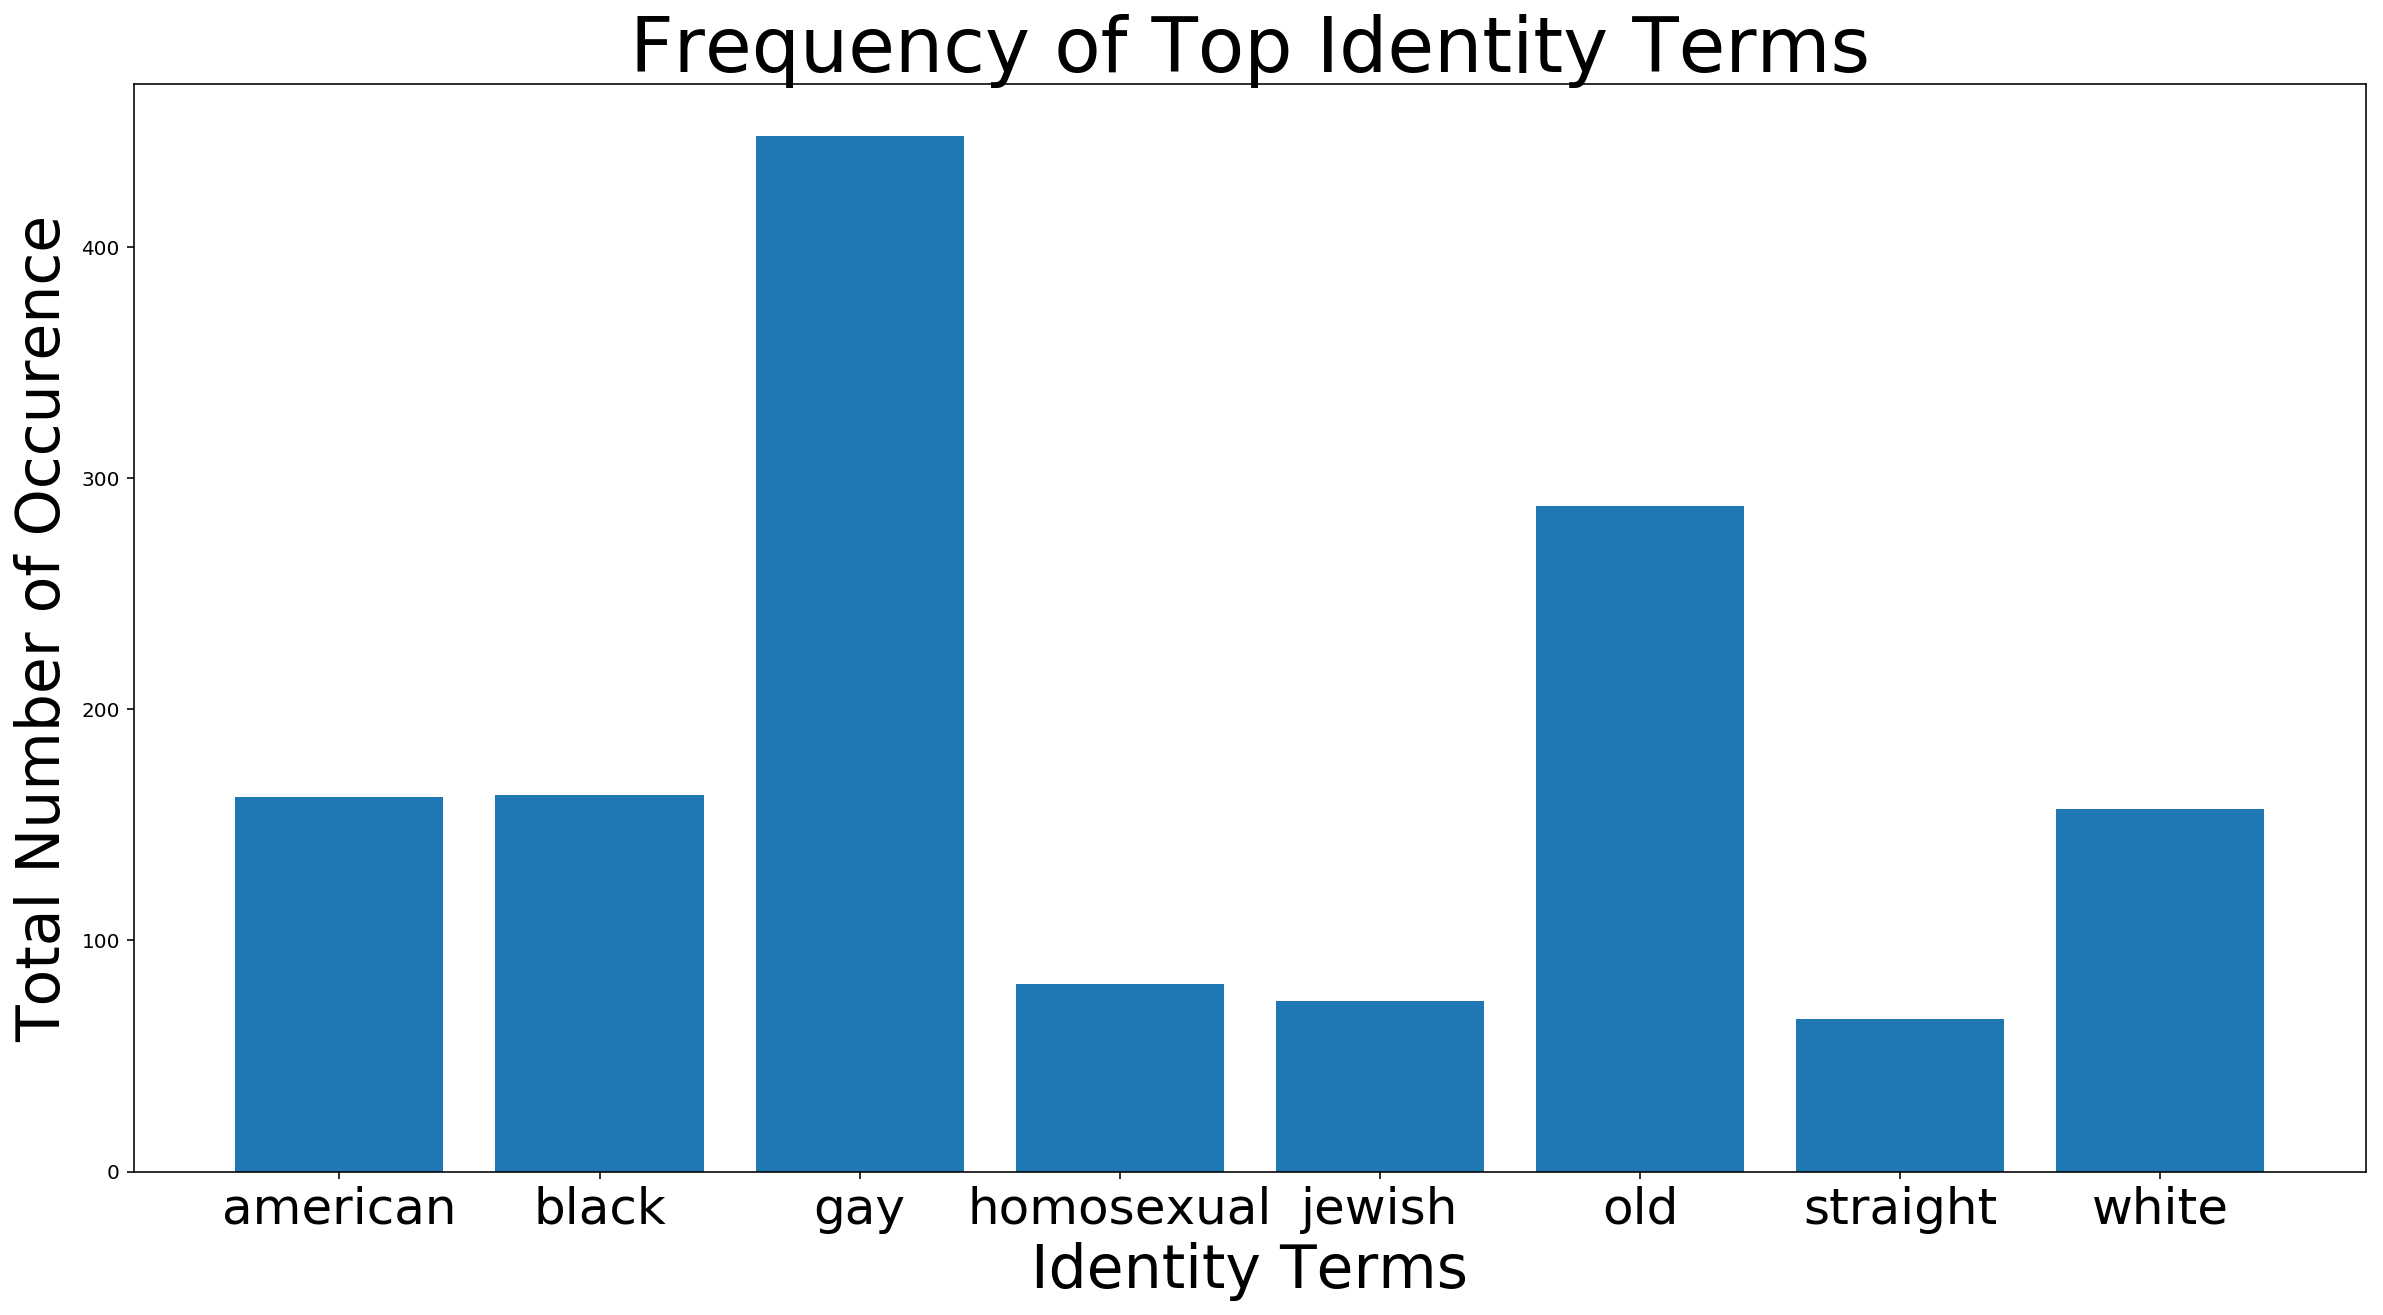

In [56]:
# This is me taking out the bottom values and making a new graph
CUTOFF_THRESHOLD = 0.03
plt.figure(figsize=(20,10))
sum_toxic_comments = 0
for i in toxic_appearances:
    sum_toxic_comments += i

new_madlibs_terms = []
new_toxic_appearances = []
for i in range(len(toxic_appearances)):
    if (toxic_appearances[i]/sum_toxic_comments) >= CUTOFF_THRESHOLD:
        new_madlibs_terms.append(madlibs_terms[i])
        new_toxic_appearances.append(toxic_appearances[i])
        
# So now, new_madlibs_terms is just the words that appear in CUTOFF_THRESHOLD% of toxic comments
# And, the corresponding how often they occur is in new_toxic_appearances

plt.bar(new_madlibs_terms, new_toxic_appearances)

# TAKE THESE OUT IF YOU DON'T WANT TO USE THIS METHODOLOGY OF FILTERING:
madlibs_terms = new_madlibs_terms
toxic_appearances = new_toxic_appearances

# plt.xticks('', fontsize=15)
plt.xticks(new_madlibs_terms, new_madlibs_terms,fontsize=25)
plt.title("Frequency of Top Identity Terms", fontsize=38)
plt.ylabel('Total Number of Occurence', fontsize=30)
plt.xlabel('Identity Terms', fontsize=30)
# urgh will need to space this out really hard. Maybe rank it, too. 

plt.savefig('Freq_of_Top_Ti.png', bbox_inches='tight')

Train logistic regression classifier.

Equation DI:
DI(t1,t2) = (probability that comment containing term t1 is labeled toxic) / (probability that comment containing term t2 is labelled toxic)
= a/b

a = # comments containing t1 AND toxic / # comments containing t1
= alpha/beta

In [9]:
def calculate_pairwise_di(df, madlibs_terms, colname):
    
    # We now calculate the DI for each pair for the training data.

    term_toxicity = np.zeros(len(madlibs_terms))

    # we temporarily put -1 in as a placeholder for stuff that has no exacmples of terms with that term.
    # non-binary is one
    for i in range(len(madlibs_terms)):
        try:
            term_toxicity[i] = float((df[(df[madlibs_terms[i]] == True) & (df[colname] == 1)].shape[0]))/  \
            float((df[df[madlibs_terms[i]] == True].shape[0]))
        except ZeroDivisionError:
            term_toxicity[i] = -1 

    return term_toxicity

term_toxicity = calculate_pairwise_di(train_comments, madlibs_terms, 'binary_tox')
print(term_toxicity)
print(len(term_toxicity))


[0.62544803 0.46774194 0.13702624 0.18042813 0.15853659 0.09857978
 0.11860465 0.12916667]
8


In [10]:
# This finds the max DI between all pairs of identity terms, which for one of our experiments,
# we're claiming is kind of the DI of all terms
# Possibly something we'll take out or come back to once we try more versions of our code. (Neha's working on this!)

def gay_ratio(term_toxicity, madlibs_terms):
    term_vs_gay = []
    top_indexes = ()
    j = 0 # This is the index of gay
    for i in range(len(madlibs_terms)):
        if (i==j or term_toxicity[i] == -1 or term_toxicity[j] == -1 or term_toxicity[j] == 0):
            term_vs_gay.append(1)
        else:
            term_vs_gay.append(term_toxicity[i]/ term_toxicity[j])
                
    return term_vs_gay


In [11]:
# Calculate max DIs on all of the perturbed training datasets
def find_gay_dis(df_comments, list_perturbation, madlibs_terms):
    
    term_vs_gay_by_pert = []
    # So this is a series of ararys.
    # one array in this is going to be one perturbation, where each array is t1/gay di, t2/gay di...

    for i in range(NUM_PERTURBATIONS):
        df_comments['newcol'] = list_perturbation[i]
        term_toxicity = calculate_pairwise_di(df_comments, madlibs_terms, 'newcol')
        term_vs_gay = gay_ratio(term_toxicity, madlibs_terms)
        term_vs_gay_by_pert.append(term_vs_gay)
        
    # This is the array of all of the max_dis, and the indexes of the madlibs_terms array that composed that max_di
    return term_vs_gay_by_pert

In [12]:
# Generates perturbations
# Basically, creates num_perturbations number of arrays. 
# Each array is the length of the train_comments
# Each item in the array is 0/1 and is PROBABILITY_FLIP flipped from the true value of binary toxicity 

PROBABILITY_FLIP = 0.75
def generate_perturbation_on_training(train_comments, num_perturbations):
    
    list_perturbation = []

    length = len(train_comments.binary_tox.values)
    for j in range(num_perturbations):
        rand = np.random.random(length) # generate a random number (between 0 and 1) for each comment
        tox_tmp = np.copy(train_comments.binary_tox.values) # np.copy(tox_np)
        for i in range(length):
            if rand[i] >= PROBABILITY_FLIP: # if random number is greater than 0.5, replace value in array with a random integer from [0, 1]
                tox_tmp[i] = np.random.randint(2)
        list_perturbation.append(tox_tmp)

    # each item in list_perturbation is a list of 0s and 1s that correspond to the new binary_tox of each variable
    
    return list_perturbation

In [13]:
NUM_PERTURBATIONS = 10
list_perturbations_training = generate_perturbation_on_training(train_comments, NUM_PERTURBATIONS)
print(list_perturbations_training)

[array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 1, 0])]


In [14]:
training_data_dis = find_gay_dis(train_comments, list_perturbations_training, madlibs_terms)
print("**", training_data_dis)


** [[1, 0.7205438066465257, 0.3735301630362978, 0.43820505002910276, 0.411170879080392, 0.33659677895645457, 0.3175577882386004, 0.37930513595166165], [1, 0.8946587537091988, 0.4054986979955187, 0.41521247924209836, 0.3544908446117102, 0.3098547555833203, 0.3504105996825616, 0.34298431538787627], [1, 0.8421052631578947, 0.33297529538131043, 0.4465636568485434, 0.384681215233205, 0.323044453238359, 0.33011015911872704, 0.3641917293233083], [1, 0.8696319018404909, 0.39922016133359567, 0.48680137333258294, 0.39892263953314383, 0.37893814290327044, 0.37417605935226145, 0.3779907975460123], [1, 0.7972972972972973, 0.40548420140256874, 0.39457806430283493, 0.3996191313264484, 0.3443744496376075, 0.3507228158390949, 0.36605534105534104], [1, 0.7941176470588236, 0.3978914874220365, 0.4226432243587923, 0.41433209997734655, 0.35070648758118206, 0.36158110735114124, 0.38458646616541353], [1, 0.8231707317073171, 0.37198677380359807, 0.40579547997314835, 0.40340571088637717, 0.30982945167797543, 0.

In [15]:
def train_and_predict(train_comments, list_perturbations_training, test_comments):

    # This trains a classifier on n different perturbed datsets
    d={}
    for x in range(NUM_PERTURBATIONS):
        d["clf{0}".format(x)] = Pipeline([
            ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
            ('tfidf', TfidfTransformer(norm = 'l2')),
            ('clf', LogisticRegression()),
        ])
        d["clf{0}".format(x)] = d["clf{0}".format(x)].\
                                    fit(train_comments['comment'], list_perturbations_training[x])
        d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
                                    d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
        print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
    # Once a classifier is trained, this goes to the test data and creates predictions on test data
    perturbed_predictions = [] # list, each item is array of predictions. element 0 is 0th perturbation and 
    # predictions based on that.
    # each item in the array is a column that indicates 0/1 for predicted not-toxic/toxic

    for i in range(NUM_PERTURBATIONS):
        perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
    return perturbed_predictions

Caution, that cell below takes a really long time.

In [16]:
perturbed_predictions = train_and_predict(train_comments, list_perturbations_training, test_comments)
print(perturbed_predictions)

x Test ROC AUC: 0.93029
x Test ROC AUC: 0.93012
x Test ROC AUC: 0.93225
x Test ROC AUC: 0.93237
x Test ROC AUC: 0.92971
x Test ROC AUC: 0.93068
x Test ROC AUC: 0.92622
x Test ROC AUC: 0.92913
x Test ROC AUC: 0.93205
x Test ROC AUC: 0.92814
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 1, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]


In [17]:
# For each of the perturbed_predictions, append it onto the dataset, find the pairwise DI, and then find the max DI.
# Goal: Compute fairness on test dataset.
test_data_dis = find_gay_dis(test_comments, perturbed_predictions, madlibs_terms)

print("**", test_data_dis)
# This is the array of all of the max_dis, and the indexes of the madlibs_terms array that composed that max_di



** [[1, 0.5103850050658562, 0.13133119939747692, 0.15170212765957447, 0.1598087918267879, 0.0972345653196717, 0.11571481896229936, 0.11551216603942319], [1, 0.6970899470899471, 0.13716814159292035, 0.14466666666666667, 0.1593245227606461, 0.08463008463008462, 0.10071474983755685, 0.11762988908347925], [1, 0.6488749345892203, 0.13566079937761355, 0.17032967032967036, 0.15757370382921046, 0.09625509625509626, 0.11952959321380374, 0.11932025942533825], [1, 0.6634563937934724, 0.12329720592622054, 0.2089887640449438, 0.19180319754491906, 0.11125527979460563, 0.15276956436033903, 0.13115173458745744], [1, 0.6378600823045267, 0.1354747077460942, 0.15308641975308643, 0.1685973785826943, 0.10343677010343677, 0.12309580535701392, 0.13740243454195583], [1, 0.6787082649151615, 0.1261316244532601, 0.1710344827586207, 0.17266697047951796, 0.10505803609251886, 0.12502520669489817, 0.12480624836443426], [1, 0.7380952380952381, 0.14523685580426862, 0.1750588235294118, 0.20082923037056233, 0.1030495736

In [ ]:
test_data_dis = np.array(test_data_dis).T
training_data_dis = np.array(training_data_dis).T

Text(0.5,0,'Test Data DI')

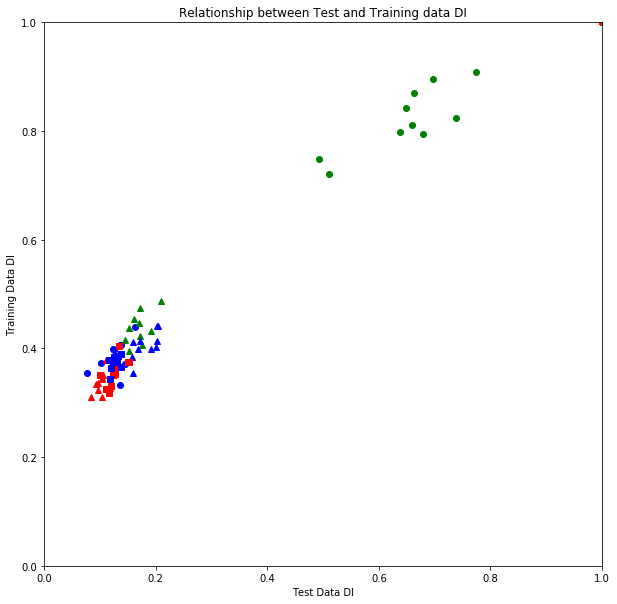

In [32]:
# SO THATS IT
# compare test_data_dis and training_data_dis for all 10 perturbation differences. 

# print("$", test_data_dis)
# print("$$", training_data_dis)

# currently, training data_dis is 10 arrays, one for each perturbation,
# and each element in the array is for the 0th toxicity term, etc
# we want it to be an array for each toxicity (so kinda flipping the matrix, I'm pretty sure)

# test_data_dis = np.array(test_data_dis).T
# print("*", test_data_dis)


# training_data_dis = np.array(training_data_dis).T
# print("**", training_data_dis)

# omg is there a shorter way than typing out all of these?
plt.figure(figsize=(10,10))
plt.plot(test_data_dis[0], training_data_dis[0], "ro", \
         test_data_dis[1], training_data_dis[1], "go",
         test_data_dis[2], training_data_dis[2], "bo", \
         test_data_dis[3], training_data_dis[3], "g^", \
         test_data_dis[4], training_data_dis[4], "b^", \
         test_data_dis[5], training_data_dis[5], "r^", \
         test_data_dis[6], training_data_dis[6], "rs",  \
         test_data_dis[7], training_data_dis[7], "bs")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title("Relationship between Test and Training data DI")
plt.ylabel('Training Data DI')
plt.xlabel('Test Data DI')
# plt.legend()

### Neha's notes

"This data set (https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973) includes over 100k labeled discussion comments from English Wikipedia. Each comment was labeled by multiple annotators via Crowdflower on whether it is a toxic or healthy contribution. We also include some demographic data for each crowd-worker. See our wiki for documentation of the schema of each file and our research paper for documentation on the data collection and modeling methodology. For a quick demo of how to use the data for model building and analysis, check out this ipython notebook." - quote from linked page

In [19]:
comments = pd.read_csv("toxicity_annotated_comments.tsv"\
                                          , sep = "\t")

Copied from documentation: <br>
"Schema for {attack/aggression/toxicity}_annotated_comments.tsv
The comment text and metadata for comments with attack/aggression/toxicity labels generated by crowd-workers. The actual labels are in the corresponding {attack/aggression/toxicity}_annotations.tsv since each comment was labeled multiple times.

rev_id: MediaWiki revision id of the edit that added the comment to a talk page (i.e. discussion). <br>
comment: Comment text. Consists of the concatenation of content added during a revision/edit of a talk page. MediaWiki markup and HTML have been stripped out. To simplify tsv parsing, \n has been mapped to NEWLINE_TOKEN, \t has been mapped to TAB_TOKEN and " has been mapped to `. <br>
year: The year the comment was posted in. <br>
logged_in: Indicator for whether the user who made the comment was logged in. Takes on values in {0, 1}. <br>
ns: Namespace of the discussion page the comment was made in. Takes on values in {user, article}. <br>
sample: Indicates whether the comment came via random sampling of all comments, or whether it came from random sampling of the 5 comments around a block event for violating WP:npa or WP:HA. Takes on values in {random, blocked}. <br>
split: For model building in our paper we split comments into train, dev and test sets. Takes on values in {train, dev, test}."
<br>

My notes: <br> 
I don't know enough about how natural language processing works, but from the snippets that I do know, I imagine that the really really long comments probably aren't very good at being classified even. I also wonder about how bigram toxicity works and whether this is something the training data accounts for (eg "nasty woman" vs "nasty" has different sources of problems). What are they classifying on/why does this work? We can see Figure 1 in the Dixon paper for comment length and should be able to filter there. I wonder if the phrase templating of classification works for the problems that I raise of large comment length and bigrams. Is this an issue we should be dealing with?
Also, an easier couple of questions are: what does the ns and sample really mean?

In [20]:
comments.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


Copied from documentation:
        Schema for toxicity_annotations.tsv
    Toxicity labels from several crowd-workers for each comment in toxicity_annotated_comments.tsv. It can be joined with toxicity_annotated_comments.tsv on rev_id.

rev_id: MediaWiki revision id of the edit that added the comment to a talk page (i.e. discussion). <br>
worker_id: Anonymized crowd-worker id.<br>
toxicity_score: Categorical variable ranging from very toxic (-2), to neutral (0), to very healthy (2). <br>
toxicity: Indicator variable for whether the worker thought the comment is toxic. The annotation takes on the value 1 if the worker considered the comment toxic (i.e worker gave a toxicity_score less than 0) and value 0 if the worker considered the comment neutral or healthy (i.e worker gave a toxicity_score greater or equal to 0). Takes on values in {0, 1}.

My notes:
Things to explore is how many people rated each thing? The paper said 10, but I would like to confirm this. 

In [21]:
annotations = pd.read_csv("toxicity_annotations.tsv"\
                                          , sep = "\t")

My comment:
    This isn't really one we'll be using until much later, if/when we decide we're doing a perturbation using demographic data. Would first want to check to see what kind of correlations might/do exist between gender/rating and see how they rate comments about women, for example.
    

Copied from documentation:

Schema for {attack/aggression/toxicity}_worker_demographics.tsv
Demographic information about the crowdworkers. This information was obtained by an optional demographic survey administered after the labelling task. It is meant to be joined with {attack/aggression/toxicity}_annotations.tsv on worker_id. Some fields may be blank if left unanswered.

worker_id: Anonymized crowd-worker id. <br>
gender: The gender of the crowd-worker. Takes a value in {'male', 'female', and 'other'}. <br>
english_first_language: Does the crowd-worker describe English as their first language. Takes a value in {0, 1}.<br>
age_group: The age group of the crowd-worker. Takes on values in {'Under 18', '18-30', '30-45', '45-60', 'Over 60'}.<br>
education: The highest education level obtained by the crowd-worker. Takes on values in {'none', 'some', 'hs', 'bachelors', 'masters', 'doctorate', 'professional'}. Here 'none' means no schooling, some means 'some schooling', 'hs' means high school completion, and the remaining terms indicate completion of the corresponding degree type.
